In [6]:
import os
import spectral as sp
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import spectral.io.envi as envi
from spectral import imshow, view_cube
from tqdm import tqdm
import pandas as pd
import utm
import json
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [7]:
data_x = json.load(open('data_x_J.json'))
data_y = json.load(open('data_y_J.json'))

In [8]:
np.array(data_x).shape

(10, 21, 82)

In [9]:
# Flatten the data
data_x = np.array(data_x).reshape(210, 82)
data_y = np.array(data_y).reshape(210)

In [10]:
S1_x, S1_y = data_x[:90], data_y[:90]
S2_x, S2_y = data_x[90:150], data_y[90:150]
S3_x, S3_y = data_x[150:], data_y[150:]

In [5]:
# train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HyperDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = np.array(data_x)
        self.data_y = np.array(data_y)
        self.m_x = np.mean(self.data_x)
        self.s_x = np.std(self.data_x)
        self.m_y = np.mean(self.data_y)
        self.s_y = np.std(self.data_y)

    def __len__(self):
        return len(self.data_x)
    
    def mean_x(self):
        return self.m_x
    def std_x(self):
        return self.s_x
    def mean_y(self):
        return self.m_y
    def std_y(self):
        return self.s_y
        
    def __getitem__(self, index):
        x = self.data_x[index]
        y = self.data_y[index]
        return torch.Tensor(x), torch.FloatTensor([y])
    
train_data = HyperDataset(S1_x, S1_y)
val_data = HyperDataset(S2_x, S2_y)
test_data = HyperDataset(S3_x, S3_y)

In [74]:
train_data[0][0].shape

torch.Size([82])

In [10]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
# Define the model
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        
        self.sequence = nn.Sequential(
            # nn.Conv1d(1, 16, 3),
            # nn.ReLU(),
            # nn.Conv1d(16, 32, 3),
            # nn.ReLU(),
            # nn.Flatten(),
            # nn.Dropout(0.5),
            # nn.GELU(),
            # nn.Linear(64, 32),
            # nn.Dropout(0.5),
            # nn.ReLU(),
            nn.Linear(82, 1),
            # nn.ReLU(),
            # nn.Linear(10, 5),
            # nn.ReLU(),
            # nn.Linear(5, 1)
        )

    def forward(self, x):
        x = self.sequence(x)
        return x
    
model = RegressionModel().to(device)

In [16]:
# Define the Gradient Boosting model
class GradientBoostingRegressor(nn.Module):
    def __init__(self, n_estimators=100, device='cuda'):
        super(GradientBoostingRegressor, self).__init__()
        self.n_estimators = n_estimators
        self.device = device
        
        # Create a list of weak learners (fully-connected neural networks)
        self.weak_learners = nn.ModuleList([self.create_weak_learner() for _ in range(n_estimators)])
        
        # Initialize the output weights
        self.output_weights = torch.ones(n_estimators, 1, requires_grad=True, device=self.device)

    def create_weak_learner(self):
        return nn.Sequential(
            nn.Linear(82, 1),
            # nn.GELU(),
            # nn.Dropout(0.3),
            # nn.Linear(64, 32),
            # nn.Sigmoid(),
            # nn.Dropout(0.3),
            # nn.Linear(32, 1),
        ).to(self.device)

    def forward(self, x):
        batch_size = x.size(0)
        outputs = torch.zeros(batch_size, 1, device=self.device)
        # print(outputs.shape)

        for i, weak_learner in enumerate(self.weak_learners):
            outputs += self.output_weights[i] * weak_learner(x)

        return outputs
    
model = GradientBoostingRegressor(n_estimators=10, device=device)

In [12]:
def r2_loss(y_true, y_pred):
    ss_total = torch.sum((y_true - torch.mean(y_true)) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / (ss_total + 1e-6))  # Avoid division by zero
    return -r2  # Return negative R^2 for minimization

In [13]:
def mae_loss(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

In [14]:
def adjusted_r2_loss(y_true, y_pred, n_features):
    r2 = r2_loss(y_true, y_pred)
    n = y_true.size(0)
    p = n_features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return -adjusted_r2

In [29]:
# model.load_state_dict(torch.load('runs/100000_J_conv_best.pth'))
model.eval()
out = []
y = []
with torch.no_grad():
    loss = 0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        # x = x.unsqueeze(1)
        print(x.shape)
        output = model(x)
        print(output.shape)
        
        loss += nn.MSELoss()(y, output).item()
        print(nn.MSELoss()(y, output).item())
        
    loss /= len(train_loader)
    print(loss)

torch.Size([32, 82])
torch.Size([32, 1])
31587236.0
torch.Size([32, 82])
torch.Size([32, 1])
40504824.0
torch.Size([26, 82])
torch.Size([26, 1])
28193418.0
33428492.666666668


In [17]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR

#Set up the training loop
loss_fn = adjusted_r2_loss
# loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1)
num_epochs = 20000
lr1 = ReduceLROnPlateau
lr2 = CyclicLR

In [131]:
loss_fn.__name__

'adjusted_r2_loss'

In [20]:
def save_checkpoint(state, is_best, epoch):
    torch.save(state[f'state_dict'], f'runs/{epoch}_J_conv_grad_last.pth')
    if is_best:
        # print('Found best')
        torch.save(state[f'state_dict'], f'runs/{epoch}_J_conv_grad_best.pth')

In [137]:
import pandas as pd
import wandb
# from IPython.display import clear_output
def train(model, epoch, train_dataloader, val_dataloader, optimizer, lr_list, loss_fn, resume = False):
    if resume == False:
        best_loss = float('inf')
        result = {'epoch':[] ,'train_loss_total':[], "val_loss_total":[], 'lr':[]}
        lr_ROP = None
        lr_else = []
        for lr in lr_list:
            if lr.__name__ == 'ReduceLROnPlateau':
                lr_ROP = lr(optimizer, mode='max', factor=0.1, patience=10, threshold=0, eps=0)
            elif lr.__name__ == 'CyclicLR':
                lr_else.append(lr(optimizer, base_lr=1e-4, max_lr=1e-2, step_size_up=2000, cycle_momentum=False))
    else:
        r_prev = pd.read_csv(f'runs/result.csv')
        result = r_prev.to_dict('list')
        best_loss = min(r_prev['val_loss_total'])
        optimizer = torch.optim.Adam(model.parameters(), lr=float(eval(result['lr'][-1])[0]))
        
        lr_ROP = None
        lr_else = []
        for lr in lr_list:
            if lr.__name__ == 'ReduceLROnPlateau':
                lr_ROP = lr(optimizer, mode='max', factor=0.1, patience=10, threshold=0, eps=0)
            elif lr.__name__ == 'CyclicLR':
                lr_else.append(lr(optimizer, base_lr=1e-4, max_lr=1e-2, step_size_up=2000, cycle_momentum=False))
        model.load_state_dict(torch.load(f"runs/{epoch}_last.pth"))
        
        
    early_stop = 1000
    count_stop = 0
    
            
    # Initialize Weights & Biases
    wandb.init(
        project="J1-regressor", 
        config={
            "learning_rate": lr_ROP.get_last_lr(),
            "epochs": epoch,
        })
     
    with tqdm(range(epoch), desc="Epoch", unit="epoch") as pbar:   
        for e in pbar:
            # Training loop
            if resume == False:
                result['epoch'].append(e+1)
            else:
                result['epoch'].append(e+1 + len(result['epoch']))
            loss_epoch = 0
            model.train()

            for batch_data, batch_labels in train_dataloader:

                batch_data = batch_data.to(device).unsqueeze(1)
                # batch_data = (batch_data - train_data.mean_x())/train_data.std_x() # Normalize the data
                #batch_labels = batch_labels.movedim(0, 1)

                # Forward pass
                label = batch_labels.to(device)
                # label = (label - train_data.mean())/train_data.std() # Normalize the labels

                output = model(batch_data)

                # Optim
                optimizer.zero_grad()
                if loss_fn.__name__ == 'adjusted_r2_loss':
                    loss = loss_fn(output, label, 82)
                # else:
                #     loss = loss_fn(output, label)
                loss_epoch += loss.item()
                loss.backward()
                optimizer.step()
                


            # Combined loss
            loss_epoch /= len(train_dataloader)
            result['train_loss_total'].append(loss_epoch)

            # print('Loss: ', loss_epoch)

            # Vaidating
            num_batches = len(val_dataloader)
            model.eval()


            test_loss = 0
        
            with torch.no_grad():
                # print('Val------')
                for X, y in val_dataloader:

                    X = X.to(device).unsqueeze(1)
                    # X = (X - train_data.mean_x())/train_data.std_x() # Normalize the data
                    pred = model(X)

                    label = y.to(device)
                    # label = (label - train_data.mean())/train_data.std() # Normalize the labels   
                    if loss_fn.__name__ == 'adjusted_r2_loss':
                        loss = loss_fn(pred, label, 82)
                    # else:
                    #     loss = loss_fn(pred, label)
                    test_loss += loss.item()
                    
                    for lr in lr_else:
                        lr.step()

            test_loss /= num_batches
            lr_ROP.step(test_loss)
            result['lr'].append(lr_ROP.get_last_lr())
            
            result['val_loss_total'].append(test_loss)
            
            # Update the progress bar with 100*n epoch, train loss, and val loss
            if e % 10 == 0:
                pbar.set_postfix(train_loss=f"{loss_epoch:.4f}", val_loss=f"{test_loss:.4f}")
                wandb.log({"train_loss": loss_epoch, "val_loss": test_loss})
            
            # remember best acc@ and save checkpoint
            
            is_best = test_loss < best_loss
            if is_best:
                count_stop = 0
                pbar.set_description(f'Epoch{e}: Good with lr: {lr_ROP.get_last_lr()}', refresh=True)
            else:
                count_stop += 1
                if count_stop > early_stop:
                    print('Early stopping')
                    break
            best_loss = min(test_loss, best_loss)
            save_checkpoint({
                f'state_dict': model.state_dict(),
            }, is_best, epoch)
            
            

            # print(f"""Val Error:
            # Avg loss: {test_loss}
            # """)
            # if (e+1) % 10 == 0:
            #     clear_output(wait=True)
    r = pd.DataFrame(result)
    r.to_csv(f'runs/resultJ.csv')
    return result

In [32]:
next(iter(train_loader))[0].shape

torch.Size([32, 82])

In [61]:
train_x, train_y = torch.tensor(S1_x, dtype=torch.float).to(device), torch.tensor(S1_y, dtype=torch.float).unsqueeze(dim=1).to(device)
val_x, val_y = torch.tensor(S2_x, dtype=torch.float).to(device), torch.tensor(S2_y, dtype=torch.float).unsqueeze(dim=1).to(device)
test_x, test_y = torch.tensor(S3_x, dtype=torch.float).to(device), torch.tensor(S3_y, dtype=torch.float).unsqueeze(dim=1).to(device)

In [62]:
train_x.shape

torch.Size([90, 82])

In [63]:
train_y.shape

torch.Size([90, 1])

In [64]:
model = RegressionModel().to(device)   
model.eval()
out = model(train_x)
print(out.shape)
loss = nn.MSELoss()(train_y, out)
print(loss)

torch.Size([90, 1])
tensor(33729804., device='cuda:0', grad_fn=<MseLossBackward0>)


In [21]:
import pandas as pd
import wandb
# from IPython.display import clear_output
# def train_grad_boost(model, epoch, train_dataloader, val_dataloader, optimizer, lr_list, loss_fn, resume = False):

train_x, train_y = torch.tensor(S1_x, dtype=torch.float).to(device), torch.tensor(S1_y, dtype=torch.float).unsqueeze(dim=1).to(device)
val_x, val_y = torch.tensor(S2_x, dtype=torch.float).to(device), torch.tensor(S2_y, dtype=torch.float).unsqueeze(dim=1).to(device)
test_x, test_y = torch.tensor(S3_x, dtype=torch.float).to(device), torch.tensor(S3_y, dtype=torch.float).unsqueeze(dim=1).to(device)


def save_checkpoint_boost(state, is_best, index):
    torch.save(state, f'runs/grad_boost/grad_J_best_{index}.pth')
    if is_best:
        # print('Found best')
        torch.save(state, f'runs/grad_boost/grad_J_last_{index}.pth')
    
wandb.login()


num_model = 100
epoch = 100000
lr_list = [ReduceLROnPlateau, CyclicLR]
models = []
gammas = []
    
early_stop = 10000
count_stop = 0


train_output = torch.zeros_like(train_y).to(device)
val_output = 0
test_output = 0
train_y_new = train_y.clone()
val_y_new = val_y.clone()

# Initialize Weights & Biases
wandb.init(
    project="J1-gradboostregressor", 
    config={
        "epochs": epoch*num_model,
    })  

     

for i in range(num_model):
    with tqdm(range(epoch), desc=f"Estimator{i+1}", unit='epoch') as pbar:
        
        # Inintialize the model
        model = RegressionModel().to(device)
        loss_fn = nn.MSELoss
        optimizer = torch.optim.Adam(model.parameters(), lr=1)
        
        
        best_loss = float('inf')
        result = {'epoch':[] ,'train_loss_total':[], "val_loss_total":[], 'lr':[]}
        lr_ROP = None
        lr_else = []
        for lr in lr_list:
            if lr.__name__ == 'ReduceLROnPlateau':
                lr_ROP = lr(optimizer, mode='max', factor=0.1, patience=10, threshold=0, eps=0)
            elif lr.__name__ == 'CyclicLR':
                lr_else.append(lr(optimizer, base_lr=1e-4, max_lr=1e-2, step_size_up=2000, cycle_momentum=False))
            
        for e in pbar:
            # Training loop
            result['epoch'].append(e*(i+1)+1)

            # loss_epoch = 0
            model.train()

            # batch_data = batch_data.to(device)
            # batch_data = (batch_data - train_data.mean_x())/train_data.std_x() # Normalize the data
            #batch_labels = batch_labels.movedim(0, 1)

            # Forward pass
            # label = batch_labels.to(device)
            # label = (label - train_data.mean())/train_data.std() # Normalize the labels

            output = model(train_x)
            # Optim
            optimizer.zero_grad()
            if loss_fn.__name__ == 'adjusted_r2_loss':
                loss = loss_fn(output, train_y_new, 82)
            elif loss_fn.__name__ == 'MSELoss':
                loss = loss_fn()(output, train_y_new)
            loss_epoch = loss.item()
            loss.backward()
            optimizer.step()
                


            # Combined loss
            # loss_epoch /= len(train_loader)
            result['train_loss_total'].append(loss_epoch)

            # print('Loss: ', loss_epoch)

            # Vaidating
            model.eval()
        
            with torch.no_grad():
                # print('Val------')
                # X = (X - train_data.mean_x())/train_data.std_x() # Normalize the data
                pred = model(val_x)
                # label = (label - train_data.mean())/train_data.std() # Normalize the labels   
                if loss_fn.__name__ == 'adjusted_r2_loss':
                    loss = loss_fn(pred, val_y_new, 82)
                elif loss_fn.__name__ == 'MSELoss':
                    loss = loss_fn()(pred, val_y_new)
                test_loss = loss.item()
                
                for lr in lr_else:
                    lr.step()

            lr_ROP.step(test_loss)
            result['lr'].append(lr_ROP.get_last_lr())
            
            result['val_loss_total'].append(test_loss)
            
            # Update the progress bar with 100*n epoch, train loss, and val loss
            # if e % 10 == 0:
            pbar.set_postfix(train_loss=f"Estimator{i+1}:{loss_epoch:.4f}", val_loss=f"Estimator{i+1}:{test_loss:.4f}")
                # wandb.log({f"Estimator{i+1}_train_loss": loss_epoch, f"Estimator{i+1}:_val_loss": test_loss})
            
            # remember best acc@ and save checkpoint
            
            is_best = test_loss < best_loss
            if is_best:
                count_stop = 0
                pbar.set_description(f'Estimator{i+1}: Good with loss: {test_loss}', refresh=True)
            else:
                count_stop += 1
                if count_stop > early_stop:
                    print('Early stopping')
                    break
            best_loss = min(test_loss, best_loss)
            # save_checkpoint_boost({
            #     f'state_dict': model.state_dict(),
            # }, is_best, i)
            
        # Create new y_train
        with torch.no_grad():  
            models.append(model)
            gamma = 1* -(train_output*model(train_x) - model(train_x)*train_y).sum()/(model(train_x)**2).sum().item()
            gammas.append(gamma.item())
            train_output += gamma*model(train_x).detach()
            val_output += gamma*model(val_x).detach()
            

                
            if loss_fn.__name__ == 'adjusted_r2_loss':
                val_loss = loss_fn(val_output, val_y, 82).item()
                train_loss = loss_fn(train_output, train_y, 82).item()
            elif loss_fn.__name__ == 'MSELoss':
                val_loss = loss_fn()(val_y, val_output).item()
                train_loss = loss_fn()(train_y, train_output).item()
            wandb.log({f"Total_train_loss": train_loss, f'Total_val_loss': val_loss})
                
            train_y_new -= gamma*model(train_x).detach()
            val_y_new -= gamma*model(val_x).detach()

            # print(f"""Val Error:
            # Avg loss: {test_loss}
            # """)
            # if (e+1) % 10 == 0:
            #     clear_output(wait=True)
r = pd.DataFrame(result)
r.to_csv(f'runs/resultJ.csv')
# return result


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Estimator1: Good with loss: 9103672.0:  13%|█▎        | 12632/100000 [00:45<05:12, 279.77epoch/s, train_loss=Estimator1:5594864.5000, val_loss=Estimator1:9548383.0000]  


Early stopping


Estimator2: Good with loss: 9545950.0:  11%|█▏        | 11442/100000 [00:34<04:27, 331.52epoch/s, train_loss=Estimator2:3023771.7500, val_loss=Estimator2:11735312.0000]


Early stopping


Estimator3: Good with loss: 13771435.0:  20%|█▉        | 19703/100000 [01:11<04:52, 274.68epoch/s, train_loss=Estimator3:1704968.6250, val_loss=Estimator3:13906197.0000]


Early stopping


Estimator4: Good with loss: 10273758.0:  55%|█████▌    | 55097/100000 [03:50<03:08, 238.66epoch/s, train_loss=Estimator4:1108736.2500, val_loss=Estimator4:10560498.0000]


Early stopping


Estimator5: Good with loss: 13426900.0:  16%|█▋        | 16475/100000 [01:02<05:19, 261.82epoch/s, train_loss=Estimator5:975531.8750, val_loss=Estimator5:13800593.0000]


Early stopping


Estimator6: Good with loss: 14255553.0:  10%|█         | 10001/100000 [00:30<04:30, 332.76epoch/s, train_loss=Estimator6:924238.0625, val_loss=Estimator6:15397236.0000]


Early stopping


Estimator7: Good with loss: 16509317.0:  12%|█▏        | 11825/100000 [00:39<04:55, 298.72epoch/s, train_loss=Estimator7:881715.7500, val_loss=Estimator7:17292764.0000]


Early stopping


Estimator8: Good with loss: 18312876.0:  10%|█         | 10001/100000 [00:33<04:58, 301.11epoch/s, train_loss=Estimator8:838348.4375, val_loss=Estimator8:19079038.0000]


Early stopping


Estimator9: Good with loss: 19504354.0:  12%|█▏        | 12465/100000 [00:44<05:10, 281.48epoch/s, train_loss=Estimator9:809552.3750, val_loss=Estimator9:19871804.0000]


Early stopping


Estimator10: Good with loss: 20463766.0:  10%|█         | 10072/100000 [00:33<04:56, 303.42epoch/s, train_loss=Estimator10:764337.6875, val_loss=Estimator10:21026322.0000]


Early stopping


Estimator11: Good with loss: 21256332.0:  12%|█▏        | 11575/100000 [00:40<05:07, 287.52epoch/s, train_loss=Estimator11:740882.6250, val_loss=Estimator11:21529866.0000]


Early stopping


Estimator12: Good with loss: 22076906.0:  10%|█         | 10001/100000 [00:32<04:53, 306.80epoch/s, train_loss=Estimator12:693248.1250, val_loss=Estimator12:22594918.0000]


Early stopping


Estimator13: Good with loss: 22722074.0:  12%|█▏        | 12486/100000 [00:43<05:07, 284.37epoch/s, train_loss=Estimator13:674443.3125, val_loss=Estimator13:22816450.0000]


Early stopping


Estimator14: Good with loss: 22933186.0:  10%|█         | 10001/100000 [00:32<04:50, 309.93epoch/s, train_loss=Estimator14:625488.1250, val_loss=Estimator14:23349658.0000]


Early stopping


Estimator15: Good with loss: 23418528.0:  12%|█▏        | 11815/100000 [00:42<05:13, 281.22epoch/s, train_loss=Estimator15:609475.4375, val_loss=Estimator15:23448666.0000]


Early stopping


Estimator16: Good with loss: 23498278.0:  10%|█         | 10043/100000 [00:32<04:52, 307.96epoch/s, train_loss=Estimator16:560078.2500, val_loss=Estimator16:23780340.0000]


Early stopping


Estimator17: Good with loss: 23825456.0:  15%|█▌        | 15386/100000 [00:53<04:54, 287.71epoch/s, train_loss=Estimator17:542965.5000, val_loss=Estimator17:23839974.0000]


Early stopping


Estimator18: Good with loss: 24032102.0:  10%|█         | 10001/100000 [00:32<04:50, 309.80epoch/s, train_loss=Estimator18:471681.2188, val_loss=Estimator18:24391286.0000]


Early stopping


Estimator20: Good with loss: 26767098.0:  10%|█         | 10001/100000 [00:33<04:57, 302.94epoch/s, train_loss=Estimator20:287731.4375, val_loss=Estimator20:26833668.0000]


Early stopping


Estimator22: Good with loss: 25071934.0:  24%|██▍       | 23929/100000 [01:19<04:11, 302.35epoch/s, train_loss=Estimator22:285848.6562, val_loss=Estimator22:25115656.0000]


Early stopping


Estimator23: Good with loss: 25077362.0:  10%|█         | 10051/100000 [00:29<04:21, 344.26epoch/s, train_loss=Estimator23:285774.2812, val_loss=Estimator23:25167332.0000]


Early stopping


Estimator24: Good with loss: 25198024.0:  24%|██▍       | 23830/100000 [01:17<04:08, 306.95epoch/s, train_loss=Estimator24:285711.4062, val_loss=Estimator24:25236038.0000]


Early stopping


Estimator25: Good with loss: 25199882.0:  10%|█         | 10087/100000 [00:33<04:55, 304.56epoch/s, train_loss=Estimator25:285626.5312, val_loss=Estimator25:25281832.0000]


Early stopping


Estimator26: Good with loss: 25244904.0:  10%|█         | 10001/100000 [00:31<04:42, 318.17epoch/s, train_loss=Estimator26:285612.0000, val_loss=Estimator26:25322804.0000]


Early stopping


Estimator27: Good with loss: 25372462.0:  16%|█▌        | 15701/100000 [00:51<04:36, 304.37epoch/s, train_loss=Estimator27:285565.1250, val_loss=Estimator27:25404230.0000]


Early stopping


Estimator28: Good with loss: 25381106.0:  10%|█         | 10001/100000 [00:30<04:35, 326.79epoch/s, train_loss=Estimator28:285549.2500, val_loss=Estimator28:25427690.0000]


Early stopping


Estimator29: Good with loss: 25390312.0:  10%|█         | 10001/100000 [00:33<04:57, 302.10epoch/s, train_loss=Estimator29:285526.4375, val_loss=Estimator29:25474282.0000]


Early stopping


Estimator30: Good with loss: 25461510.0:  10%|█         | 10036/100000 [00:32<04:47, 312.79epoch/s, train_loss=Estimator30:285513.0000, val_loss=Estimator30:25502042.0000]


Early stopping


Estimator31: Good with loss: 25540584.0:  10%|█         | 10086/100000 [00:32<04:45, 314.56epoch/s, train_loss=Estimator31:285480.5312, val_loss=Estimator31:25571990.0000]


Early stopping


Estimator32: Good with loss: 25551038.0:  10%|█         | 10001/100000 [00:33<05:02, 297.61epoch/s, train_loss=Estimator32:285471.0312, val_loss=Estimator32:25596990.0000]


Early stopping


Estimator33: Good with loss: 25686106.0:  12%|█▏        | 12005/100000 [00:39<04:48, 304.86epoch/s, train_loss=Estimator33:285422.8438, val_loss=Estimator33:25743876.0000]


Early stopping


Estimator34: Good with loss: 25723940.0:  10%|█         | 10025/100000 [00:33<04:58, 301.64epoch/s, train_loss=Estimator34:285415.9062, val_loss=Estimator34:25768014.0000]


Early stopping


Estimator35: Good with loss: 25863156.0:  12%|█▏        | 11876/100000 [00:36<04:30, 325.53epoch/s, train_loss=Estimator35:285376.9375, val_loss=Estimator35:25913960.0000]


Early stopping


Estimator36: Good with loss: 25843184.0:  10%|█         | 10001/100000 [00:35<05:15, 285.43epoch/s, train_loss=Estimator36:285372.6562, val_loss=Estimator36:25935306.0000]


Early stopping


Estimator37: Good with loss: 25958006.0:  16%|█▌        | 15527/100000 [00:50<04:36, 305.39epoch/s, train_loss=Estimator37:285357.8750, val_loss=Estimator37:26002948.0000]


Early stopping


Estimator38: Good with loss: 25998462.0:  10%|█         | 10001/100000 [00:32<04:52, 307.78epoch/s, train_loss=Estimator38:285349.3438, val_loss=Estimator38:26041616.0000]


Early stopping


Estimator39: Good with loss: 26040180.0:  11%|█▏        | 11338/100000 [00:38<04:59, 296.42epoch/s, train_loss=Estimator39:285341.7500, val_loss=Estimator39:26078294.0000]


Early stopping


Estimator40: Good with loss: 26048222.0:  10%|█         | 10001/100000 [00:31<04:46, 314.18epoch/s, train_loss=Estimator40:285330.7812, val_loss=Estimator40:26133434.0000]


Early stopping


Estimator41: Good with loss: 26078966.0:  10%|█         | 10001/100000 [00:30<04:33, 328.91epoch/s, train_loss=Estimator41:285326.0938, val_loss=Estimator41:26159246.0000]


Early stopping


Estimator42: Good with loss: 26155730.0:  10%|█         | 10103/100000 [00:31<04:38, 322.22epoch/s, train_loss=Estimator42:285318.9375, val_loss=Estimator42:26198550.0000]


Early stopping


Estimator43: Good with loss: 26196952.0:  12%|█▏        | 11501/100000 [00:35<04:32, 325.17epoch/s, train_loss=Estimator43:285313.7500, val_loss=Estimator43:26234104.0000]


Early stopping


Estimator44: Good with loss: 26287020.0:  16%|█▌        | 15937/100000 [00:50<04:27, 314.40epoch/s, train_loss=Estimator44:285298.4688, val_loss=Estimator44:26338138.0000]


Early stopping


Estimator45: Good with loss: 26319668.0:  10%|█         | 10067/100000 [00:34<05:10, 289.24epoch/s, train_loss=Estimator45:285294.7500, val_loss=Estimator45:26359818.0000]


Early stopping


Estimator46: Good with loss: 26373576.0:  10%|█         | 10001/100000 [00:32<04:54, 305.52epoch/s, train_loss=Estimator46:285287.3438, val_loss=Estimator46:26411552.0000]


Early stopping


Estimator47: Good with loss: 26314494.0:  10%|█         | 10001/100000 [00:34<05:06, 293.36epoch/s, train_loss=Estimator47:285284.5625, val_loss=Estimator47:26433542.0000]


Early stopping


Estimator48: Good with loss: 26430240.0:  12%|█▏        | 11786/100000 [00:37<04:42, 312.41epoch/s, train_loss=Estimator48:285280.2188, val_loss=Estimator48:26464370.0000]


Early stopping


Estimator49: Good with loss: 26466434.0:  10%|█         | 10067/100000 [00:35<05:15, 285.27epoch/s, train_loss=Estimator49:285274.4375, val_loss=Estimator49:26510294.0000]


Early stopping


Estimator50: Good with loss: 26497734.0:  12%|█▏        | 11992/100000 [00:37<04:37, 317.28epoch/s, train_loss=Estimator50:285271.2188, val_loss=Estimator50:26539472.0000]


Early stopping


Estimator51: Good with loss: 26483610.0:  10%|█         | 10001/100000 [00:33<05:05, 295.00epoch/s, train_loss=Estimator51:285265.1250, val_loss=Estimator51:26597546.0000]


Early stopping


Estimator52: Good with loss: 26554066.0:  10%|█         | 10001/100000 [00:32<04:49, 310.77epoch/s, train_loss=Estimator52:285263.5312, val_loss=Estimator52:26613648.0000]


Early stopping


Estimator53: Good with loss: 26622150.0:  12%|█▏        | 11686/100000 [00:39<04:58, 295.39epoch/s, train_loss=Estimator53:285257.5625, val_loss=Estimator53:26666650.0000]


Early stopping


Estimator54: Good with loss: 26632176.0:  10%|█         | 10001/100000 [00:29<04:28, 335.19epoch/s, train_loss=Estimator54:285255.4375, val_loss=Estimator54:26685118.0000]


Early stopping


Estimator55: Good with loss: 26679024.0:  10%|█         | 10001/100000 [00:32<04:56, 303.67epoch/s, train_loss=Estimator55:285250.7812, val_loss=Estimator55:26729170.0000]


Early stopping


Estimator56: Good with loss: 26704400.0:  10%|█         | 10001/100000 [00:34<05:09, 291.05epoch/s, train_loss=Estimator56:285249.3438, val_loss=Estimator56:26743920.0000]


Early stopping


Estimator57: Good with loss: 26736190.0:  10%|█         | 10130/100000 [00:34<05:09, 290.19epoch/s, train_loss=Estimator57:285246.5000, val_loss=Estimator57:26774086.0000]


Early stopping


Estimator58: Good with loss: 26667752.0:  10%|█         | 10001/100000 [00:32<04:48, 311.97epoch/s, train_loss=Estimator58:285245.3750, val_loss=Estimator58:26782654.0000]


Early stopping


Estimator59: Good with loss: 26776838.0:  12%|█▏        | 11609/100000 [00:38<04:56, 298.29epoch/s, train_loss=Estimator59:285242.0625, val_loss=Estimator59:26817110.0000]


Early stopping


Estimator60: Good with loss: 26795300.0:  12%|█▏        | 12040/100000 [00:37<04:32, 322.59epoch/s, train_loss=Estimator60:285239.9062, val_loss=Estimator60:26842318.0000]


Early stopping


Estimator61: Good with loss: 26832702.0:  24%|██▍       | 23868/100000 [01:17<04:06, 309.38epoch/s, train_loss=Estimator61:285236.5000, val_loss=Estimator61:26878244.0000]


Early stopping


Estimator62: Good with loss: 26860776.0:  10%|█         | 10001/100000 [00:33<05:04, 295.66epoch/s, train_loss=Estimator62:285232.3125, val_loss=Estimator62:26927102.0000]


Early stopping


Estimator63: Good with loss: 26905730.0:  16%|█▌        | 15639/100000 [00:52<04:45, 295.42epoch/s, train_loss=Estimator63:285230.8125, val_loss=Estimator63:26948114.0000]


Early stopping


Estimator64: Good with loss: 27051286.0:  12%|█▏        | 11940/100000 [00:38<04:47, 306.76epoch/s, train_loss=Estimator64:285222.0625, val_loss=Estimator64:27088834.0000]


Early stopping


Estimator65: Good with loss: 27063270.0:  24%|██▍       | 23863/100000 [01:18<04:11, 302.22epoch/s, train_loss=Estimator65:285220.8125, val_loss=Estimator65:27109638.0000]


Early stopping


Estimator66: Good with loss: 27204320.0:  19%|█▉        | 19247/100000 [01:02<04:21, 308.33epoch/s, train_loss=Estimator66:285214.2188, val_loss=Estimator66:27234942.0000]


Early stopping


Estimator67: Good with loss: 27202062.0:  12%|█▏        | 11703/100000 [00:39<04:55, 299.27epoch/s, train_loss=Estimator67:285213.5625, val_loss=Estimator67:27242710.0000]


Early stopping


Estimator68: Good with loss: 27215622.0:  16%|█▌        | 15795/100000 [00:45<04:02, 347.70epoch/s, train_loss=Estimator68:285212.6250, val_loss=Estimator68:27261206.0000]


Early stopping


Estimator69: Good with loss: 27255152.0:   1%|          | 581/100000 [00:01<02:37, 630.23epoch/s, train_loss=Estimator69:285213.4062, val_loss=Estimator69:27255570.0000]

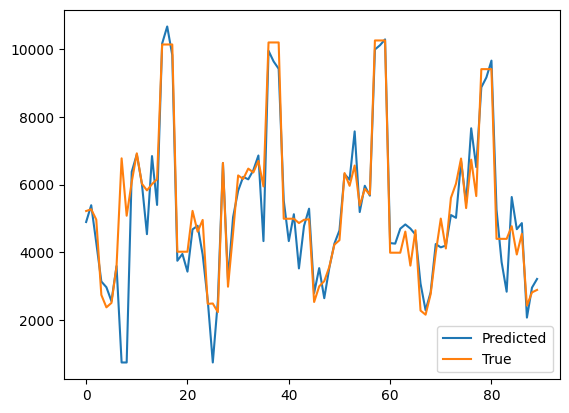

In [74]:
output=0
for model in models:
    model.eval()
    with torch.no_grad():
        # train_output += model(train_x)
        # val_output += model(val_x)
        output += model(train_x)
        
plt.plot(output.cpu().numpy(), label='Predicted')
plt.plot(train_y.cpu().numpy(), label='True')
plt.legend()
plt.show()

In [140]:
wandb.login()
result = train(model, 100000, train_loader, val_loader, optimizer, [lr1, lr2],  loss_fn, resume = False)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,-1.52906
val_loss,-1.53723


Epoch17000: Good with lr: [0.009990099999999988]:  18%|█▊        | 18001/100000 [10:36<48:17, 28.30epoch/s, train_loss=-1.5514, val_loss=-1.5439]      


Early stopping


In [ ]:
result

In [87]:
len(result['epoch'])

1475

In [141]:
# model.load_state_dict(torch.load(f"runs/100000_J_conv_last.pth"))
model.eval()
# model(torch.Tensor([train_x[1]]).to(device)), train_y[1]
with torch.no_grad():
    predict = []
    for x in tqdm(S1_x):
        # x = (x - train_data.mean_x())/train_data.std_x()
        predict.append(model(torch.Tensor([x]).to(device).unsqueeze(1)).item())

100%|██████████| 90/90 [00:00<00:00, 1328.77it/s]


In [142]:
# model.load_state_dict(torch.load(f"runs/100000_J_conv_best.pth"))
model.eval()
# model(torch.Tensor([train_x[1]]).to(device)), train_y[1]
with torch.no_grad():
    predict1 = []
    for x in tqdm(S1_x):
        # x = (x - train_data.mean_x())/train_data.std_x()
        predict1.append(model(torch.Tensor([x]).to(device).unsqueeze(1)).item())

100%|██████████| 90/90 [00:00<00:00, 1440.24it/s]


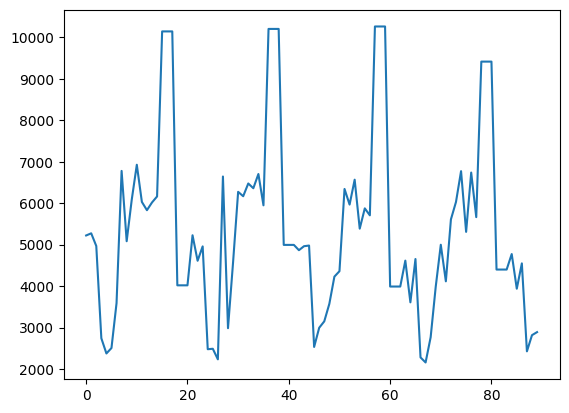

In [144]:
plt.plot([i for i in range(len(S1_y))],S1_y)

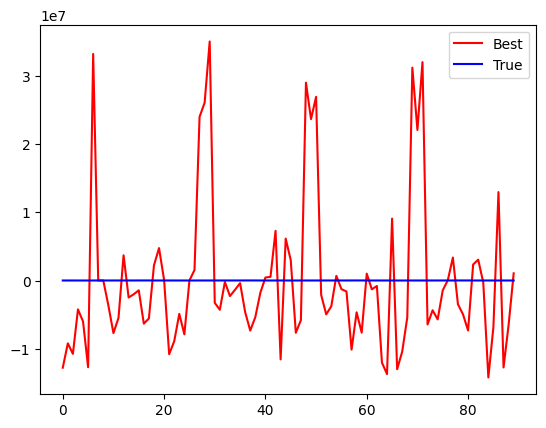

In [143]:
# plt.plot([i for i in range(len(predict))], predict, c = 'green', label = 'Last')
plt.plot([i for i in range(len(predict1))], predict1, c = 'red', label = 'Best')
plt.plot([i for i in range(len(S1_y))], S1_y, c = 'blue', label = 'True')
plt.legend()
plt.show()

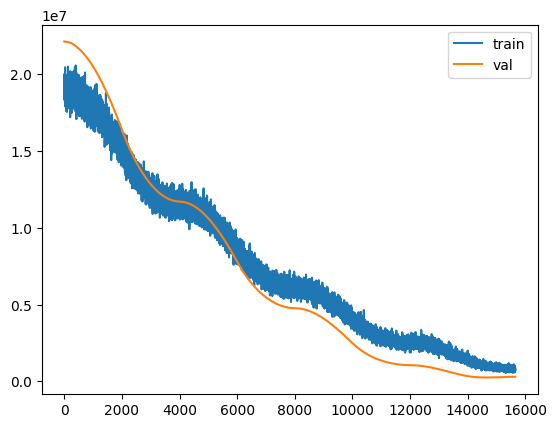

In [85]:
plt.plot(result['epoch'], result['train_loss_total'], label='train')
plt.plot(result['epoch'], result['val_loss_total'], label='val')
plt.y_ticks = np.arange(10, 100, 1000)
plt.legend()
plt.show()

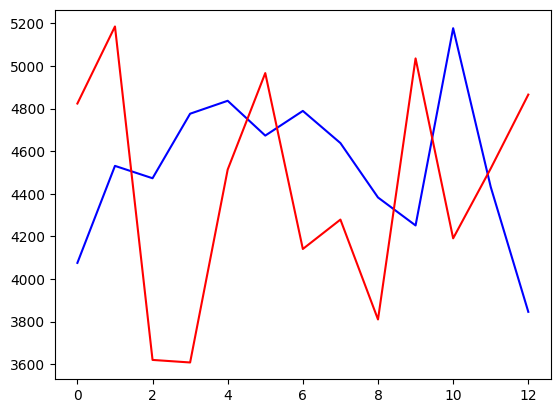

In [53]:
model.load_state_dict(torch.load('runs/20000_best.pth'))
model.eval()
predict = []
for i in test_x:
    i = (i - train_data.mean_x())/train_data.std_x()
    predict.append(model(torch.Tensor(i).to(device)).item())
# model(torch.Tensor(test_x[1]).to(device)), test_y[1]

plt.plot([i for i in range(len(test_x))], predict, c='blue')
plt.plot([i for i in range(len(test_y))], test_y, c='red')